In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from sklearn.metrics import confusion_matrix
import keras
from keras.layers import LSTM
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout

import matplotlib.pyplot as plt
import numpy as np


Found GPU at: /device:GPU:0


In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_confusion_result(x_train, x_test, y_train, y_test, model):
  # get train & test predictions
  train_pred = model.predict_classes(x_train)
  test_pred = model.predict_classes(x_test)
    
  # get train & test true labels
  train_label = y_train
  test_label =  y_test
    
  # confusion matrix
  train_result_cm = confusion_matrix(train_label, train_pred, labels=range(10))
  test_result_cm = confusion_matrix(test_label, test_pred, labels=range(10))
  plot_confusion_matrix(train_result_cm, classes=range(10),
                      title='Train Confusion matrix')
  plot_confusion_matrix(test_result_cm, classes=range(10),
                      title='Test Confusion matrix')
  # print(train_result_cm, '\n'*2, test_result_cm)

def data_preprocess_modeling(modelname,x_train, y_train, x_test, y_test):
  # shaping data to fit lstm/cnn requirments
  if modelname == 'lstm':
    _,n_step,n_input = x_train.shape
    x_train = x_train.reshape(-1, n_step, n_input)
    x_test = x_test.reshape(-1, n_step, n_input)
  elif modelname == 'cnn':
    _,width,height = x_train.shape
    x_train = x_train.reshape(-1, width, height,1)
    x_test = x_test.reshape(-1, width, height, 1)

  # set color range to 0~1
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # one hot encoding for category number 0~9
  n_classes = 10
  y_train = keras.utils.to_categorical(y_train, n_classes)
  y_test = keras.utils.to_categorical(y_test, n_classes)


  model = Sequential()
  if modelname == 'lstm':
    model.add(LSTM(128, batch_input_shape=(None, n_step, n_input),return_sequences=True))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
  elif modelname == 'cnn':
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(width, height, 1)))
    model.add(MaxPool2D(strides=2))
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
  model.summary()
  return model, x_train, y_train, x_test, y_test


def model_training(model, x_train, y_train, x_test, y_test, learning_rate=0.001, epochs=5, batch_size=64):
  adam = Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))

def LSTM_run(x_train,y_train,x_test,y_test):
  model, x_train, y_train_ohe, x_test, y_test_ohe = data_preprocess_modeling('lstm',x_train,y_train,x_test,y_test)
  model_training(model, x_train, y_train_ohe, x_test, y_test_ohe)
  scores = model.evaluate(x_test, y_test_ohe, verbose=0)
  print('LSTM test accuracy:', scores[1])
  print_confusion_result(x_train, x_test, y_train, y_test, model)


def CNN_run(x_train,y_train,x_test,y_test):
  model, x_train, y_train_ohe, x_test, y_test_ohe = data_preprocess_modeling('cnn',x_train,y_train,x_test,y_test)
  model_training(model, x_train, y_train_ohe, x_test, y_test_ohe)
  scores = model.evaluate(x_test, y_test_ohe, verbose=0)
  print('CNN test accuracy:', scores[1])
  print_confusion_result(x_train, x_test, y_train, y_test, model)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 28, 128)           80384     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 213,258
Trainable params: 213,258
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 9s 8ms/step - loss: 0.7254 - accuracy: 0.7554 - val_loss: 0.1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


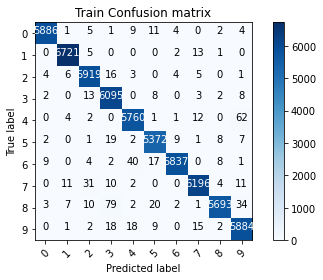

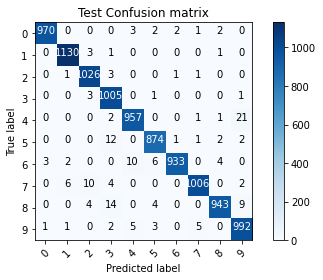

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
LSTM_run(x_train, y_train, x_test, y_test)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


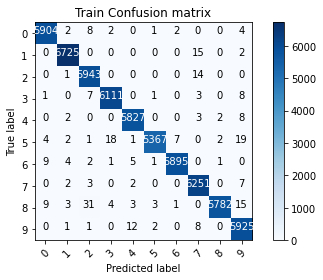

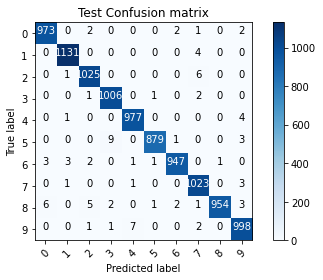

In [8]:
CNN_run(x_train, y_train, x_test, y_test)